# Air Quality - EDA

### Problem Statement: 
The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. 
<BR>
<B>Objective is to predict the Relative Humidity at a given point of time based on all other attributes affecting the change in RH.</B>

In [1]:
import os
# os.chdir('C:\Users\verma\Jupyter\Air_Quality')
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime, timedelta, date, time

In [3]:
# Read the CSV file
air_quality = pd.read_csv (r"AirQualityUCI.csv", parse_dates = ['Date'], na_values = -200).drop(['Unnamed: 15', 'Unnamed: 16'], axis = 1)
# As the column name coincides with Python class name, we change the column name
air_quality.rename(columns={'Date':'Record_Date', 'Time': 'Record_Hour'}, inplace=True)
air_quality['Record_Hour'] = pd.to_datetime(air_quality['Record_Hour'], format='%H:%M:%S')
air_quality.Record_Hour = air_quality.Record_Hour.dt.hour
display(air_quality.head())

,Record_Date,Record_Hour,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18.0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10,19.0,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10,20.0,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10,21.0,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10,22.0,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


#### Fill NaN Values

In [4]:
# Since, the values are recorded on consecutive hourly basis, filling NaN with interpolated values would be the best. 
#For Record_Date, since they are adjescent dates, we fill NaN values with forward fill
air_quality.Record_Date.fillna(method='ffill', inplace = True)
air_quality = air_quality.interpolate()
air_quality.isnull().sum()

ValueError: Invalid fill method. Expecting pad (ffill) or backfill (bfill). Got linear

### Exploratory Data Analysis - How good is the quality of data collected?

In [5]:
air_quality.describe()

,Record_Hour,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,7674.000000,8991.000000,914.000000,8991.000000,8991.000000,7718.000000,8991.000000,7715.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,11.498557,2.152750,1099.833166,218.811816,10.083105,939.153376,246.896735,835.493605,113.091251,1456.264598,1022.906128,18.317829,49.234201,1.025530
std,6.923182,1.453252,217.080037,204.459921,7.449820,266.831429,212.979168,256.817320,48.370108,346.206794,398.484288,8.832116,17.316892,0.403813
min,0.000000,0.100000,647.000000,7.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,5.000000,1.100000,937.000000,67.000000,4.400000,734.500000,98.000000,658.000000,78.000000,1227.000000,731.500000,11.800000,35.800000,0.736800
50%,11.000000,1.800000,1063.000000,150.000000,8.200000,909.000000,180.000000,806.000000,109.000000,1463.000000,963.000000,17.800000,49.600000,0.995400
75%,18.000000,2.900000,1231.000000,297.000000,14.000000,1116.000000,326.000000,969.500000,142.000000,1674.000000,1273.500000,24.400000,62.500000,1.313700
max,23.000000,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


#### Inference
1. NMHC(GT) has very high max value as compared to mean but IQR values look OK. It appears, there could be outliers
2. Some of the input variables have very high std deviation but IQRrange is OK: CO(GT), C6H6(GT) and NOx(GT). There could be some skewness in the data

<Axes: xlabel='AH', ylabel='RH'>

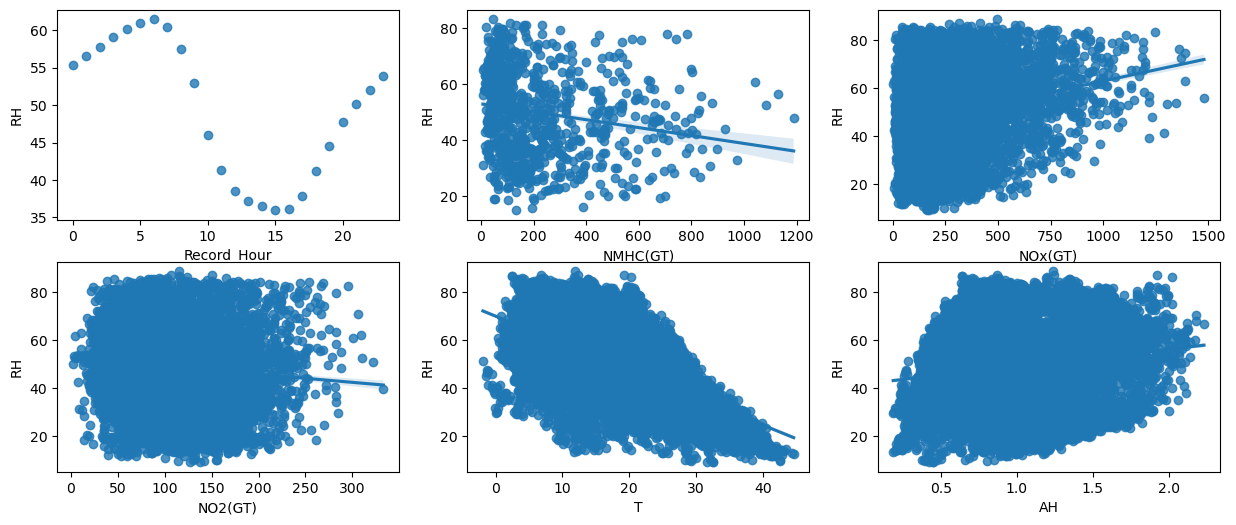

In [6]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(15,6))
RHVsRecordHour = air_quality[['RH', 'Record_Hour']].groupby('Record_Hour').mean().reset_index()
sns.regplot(x = RHVsRecordHour.Record_Hour, y=RHVsRecordHour.RH, scatter= True, fit_reg=False, ax=ax1)

sns.regplot(x = air_quality['NMHC(GT)'], y=air_quality.RH, scatter= True, fit_reg=True, ax=ax2)
sns.regplot(x = air_quality['NOx(GT)'], y=air_quality.RH, scatter= True, fit_reg=True, ax=ax3)
sns.regplot(x = air_quality['NO2(GT)'], y=air_quality.RH, scatter= True, fit_reg=True, ax=ax4)
sns.regplot(x = air_quality['T'], y=air_quality.RH, scatter= True, fit_reg=True, ax=ax5)
sns.regplot(x = air_quality['AH'], y=air_quality.RH, scatter= True, fit_reg=True, ax=ax6)

#### Inference
1. NOx seems to be positively correlated to RH(o/p variable) whereas temp and NMHC(GT) appear to be -vely correlated with RH
2. RH varies cyclically with Hour

### What is the pattern of air quality during the day?

<Axes: xlabel='Record_Hour', ylabel='NO2(GT)'>

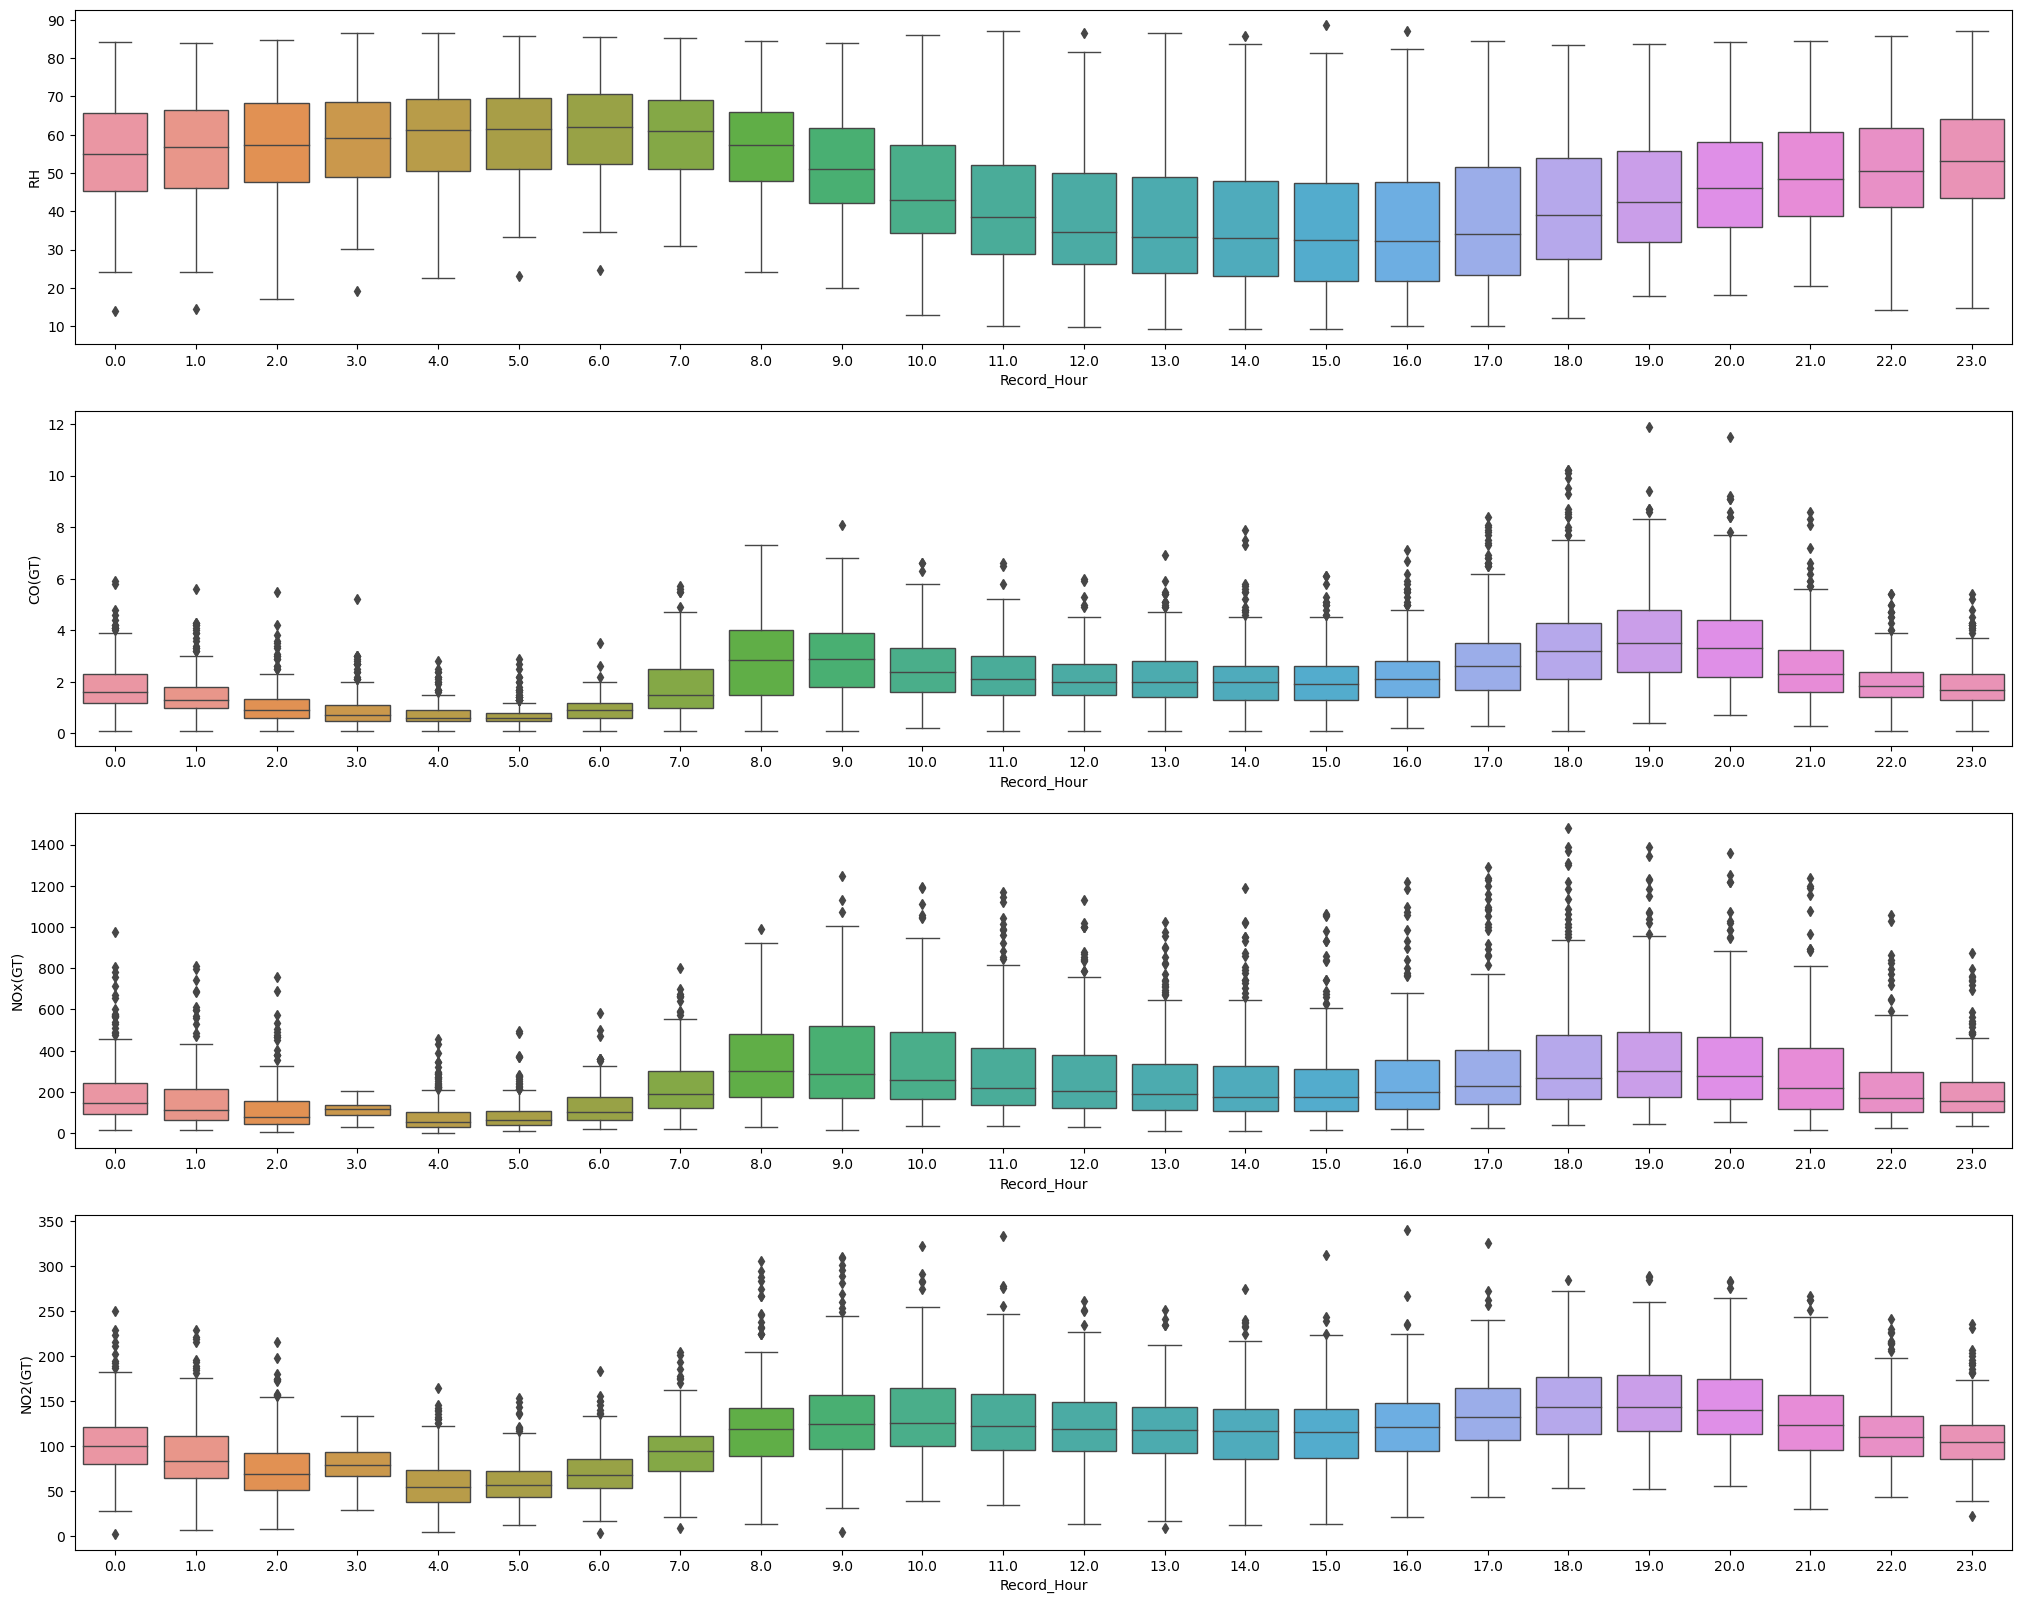

In [7]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(nrows=4, ncols=1, figsize=(25,20))
sns.boxplot(x='Record_Hour', y='RH', data=air_quality, linewidth=1, ax=ax1)
sns.boxplot(x='Record_Hour', y='CO(GT)', data=air_quality, linewidth=1, ax = ax2)
sns.boxplot(x='Record_Hour', y='NOx(GT)', data=air_quality, linewidth=1, ax = ax3)
sns.boxplot(x='Record_Hour', y='NO2(GT)', data=air_quality, linewidth=1, ax = ax4)

#### Inference
1. CO(GT), NOx(GT) and NO2(GT) seems to follow similar pattern during the day. They peak during daytime or office hours(8 am to 8 pm)
2. RH(Out Variable) seems to follow a different pattern during the day, it shows higher values during night(8 pm to 8 am) than daytime

<Axes: xlabel='AH', ylabel='Density'>

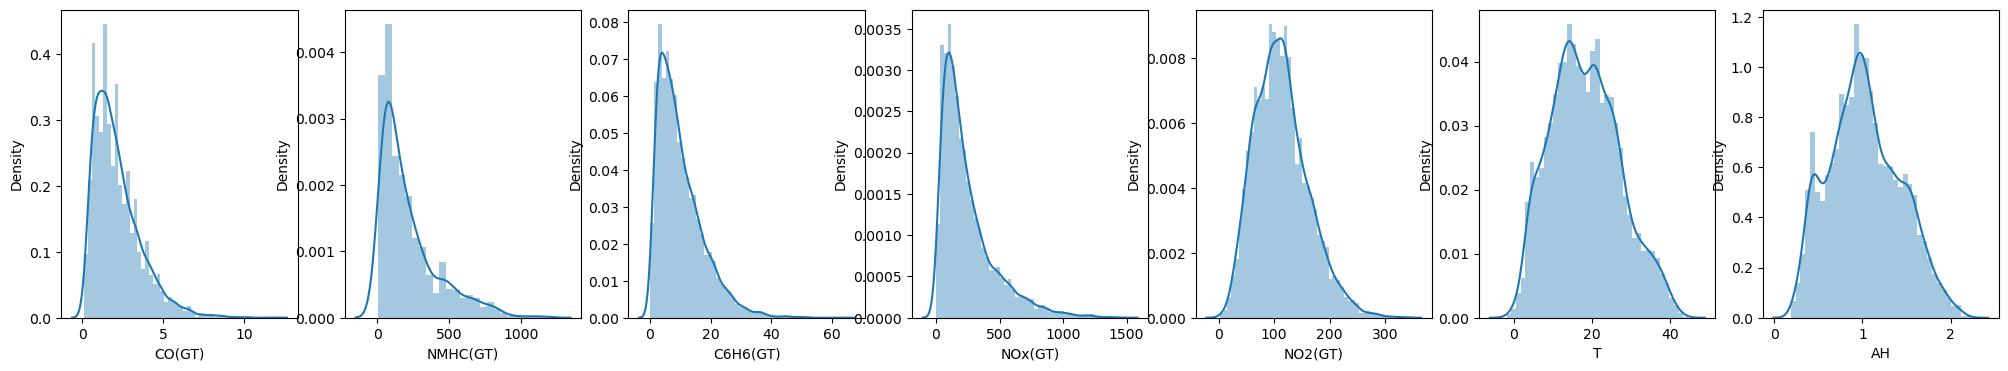

In [8]:
fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7)) = plt.subplots(nrows=1, ncols=7, figsize=(25,4))
sns.distplot(air_quality["CO(GT)"], ax = ax1)
sns.distplot(air_quality["NMHC(GT)"], ax = ax2)
sns.distplot(air_quality["C6H6(GT)"], ax = ax3)
sns.distplot(air_quality["NOx(GT)"], ax = ax4)
sns.distplot(air_quality["NO2(GT)"], ax = ax5)
sns.distplot(air_quality["T"], ax = ax6)
sns.distplot(air_quality["AH"], ax = ax7)

#### Inference
The distribution graph confirms the observation recorded in statistical observation recorded earlier

array([[<Axes: title={'center': 'Record_Hour'}>,
        <Axes: title={'center': 'CO(GT)'}>,
        <Axes: title={'center': 'PT08.S1(CO)'}>,
        <Axes: title={'center': 'NMHC(GT)'}>],
       [<Axes: title={'center': 'C6H6(GT)'}>,
        <Axes: title={'center': 'PT08.S2(NMHC)'}>,
        <Axes: title={'center': 'NOx(GT)'}>,
        <Axes: title={'center': 'PT08.S3(NOx)'}>],
       [<Axes: title={'center': 'NO2(GT)'}>,
        <Axes: title={'center': 'PT08.S4(NO2)'}>,
        <Axes: title={'center': 'PT08.S5(O3)'}>,
        <Axes: title={'center': 'T'}>],
       [<Axes: title={'center': 'RH'}>, <Axes: title={'center': 'AH'}>,
        <Axes: >, <Axes: >]], dtype=object)

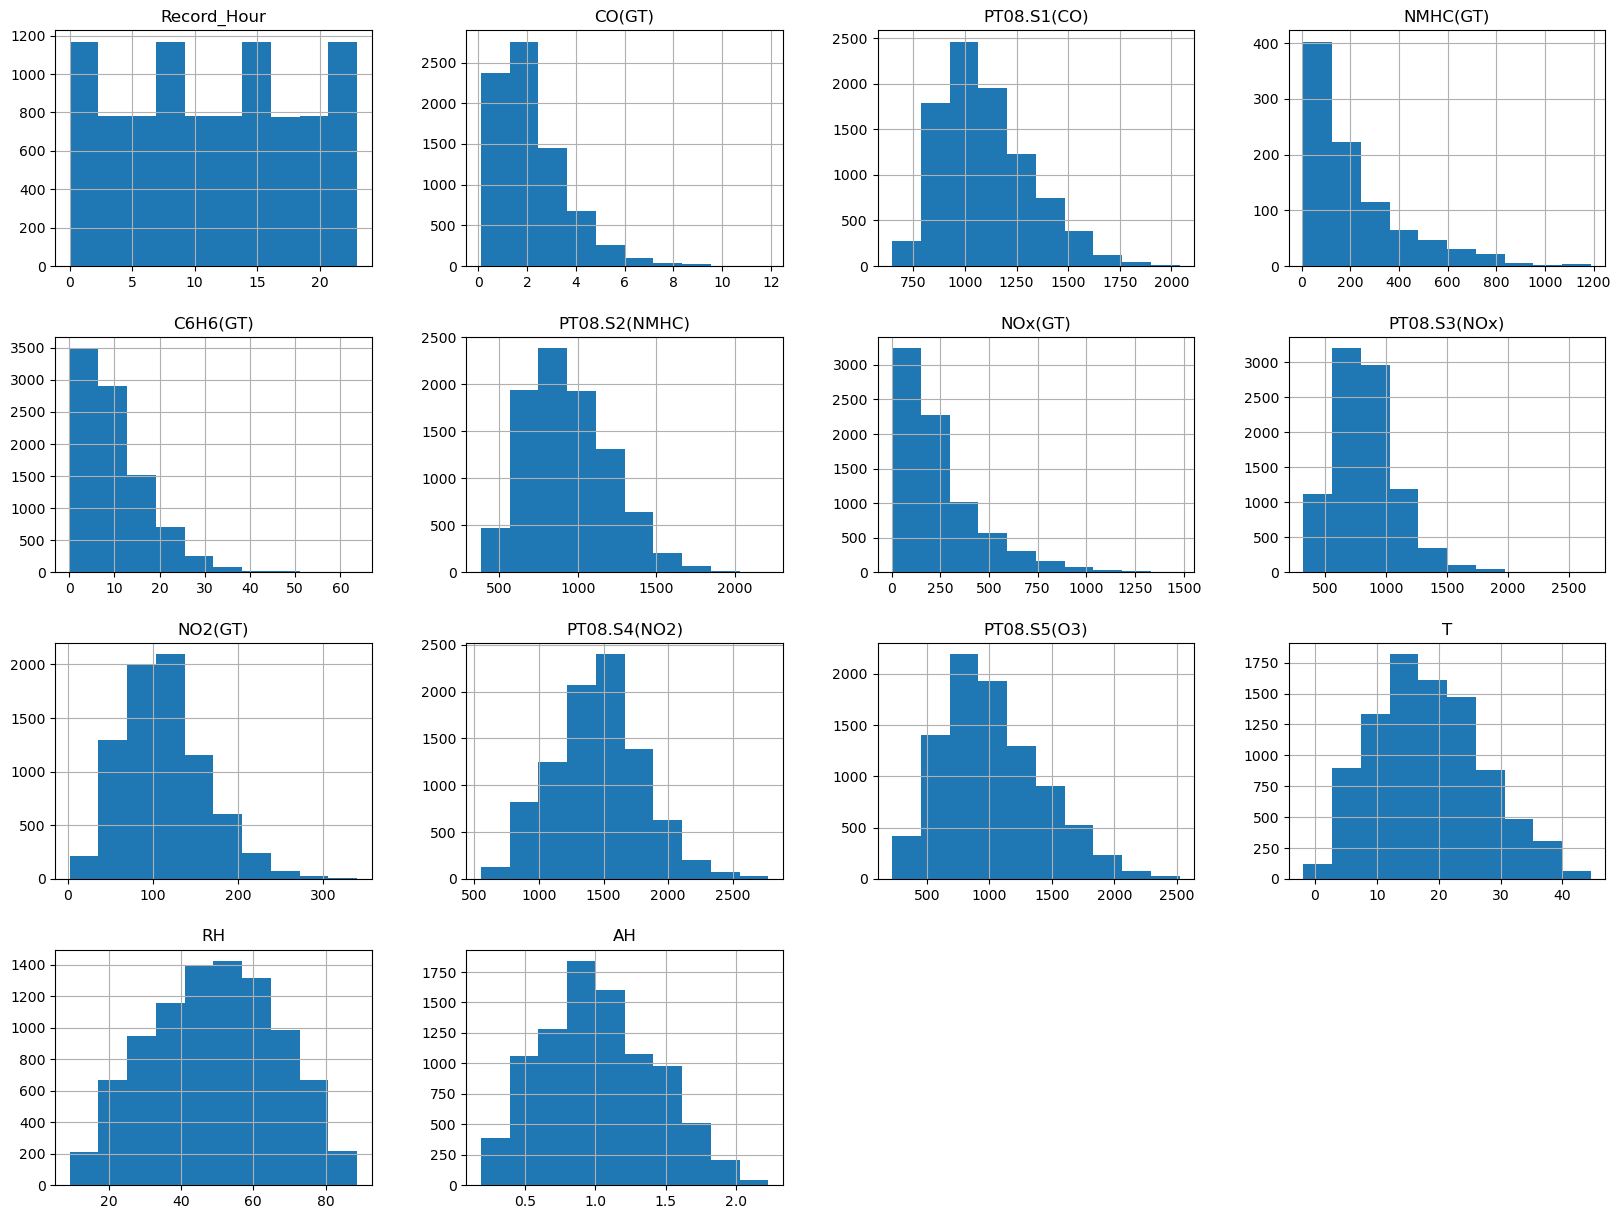

In [9]:
air_quality[air_quality.dtypes[(air_quality.dtypes=="float64")|(air_quality.dtypes=="int64")]
                        .index.values].hist(figsize=[20,15])

### Which factors has +ve relationship with Relative Humidity and which have –ve relation?

<Axes: >

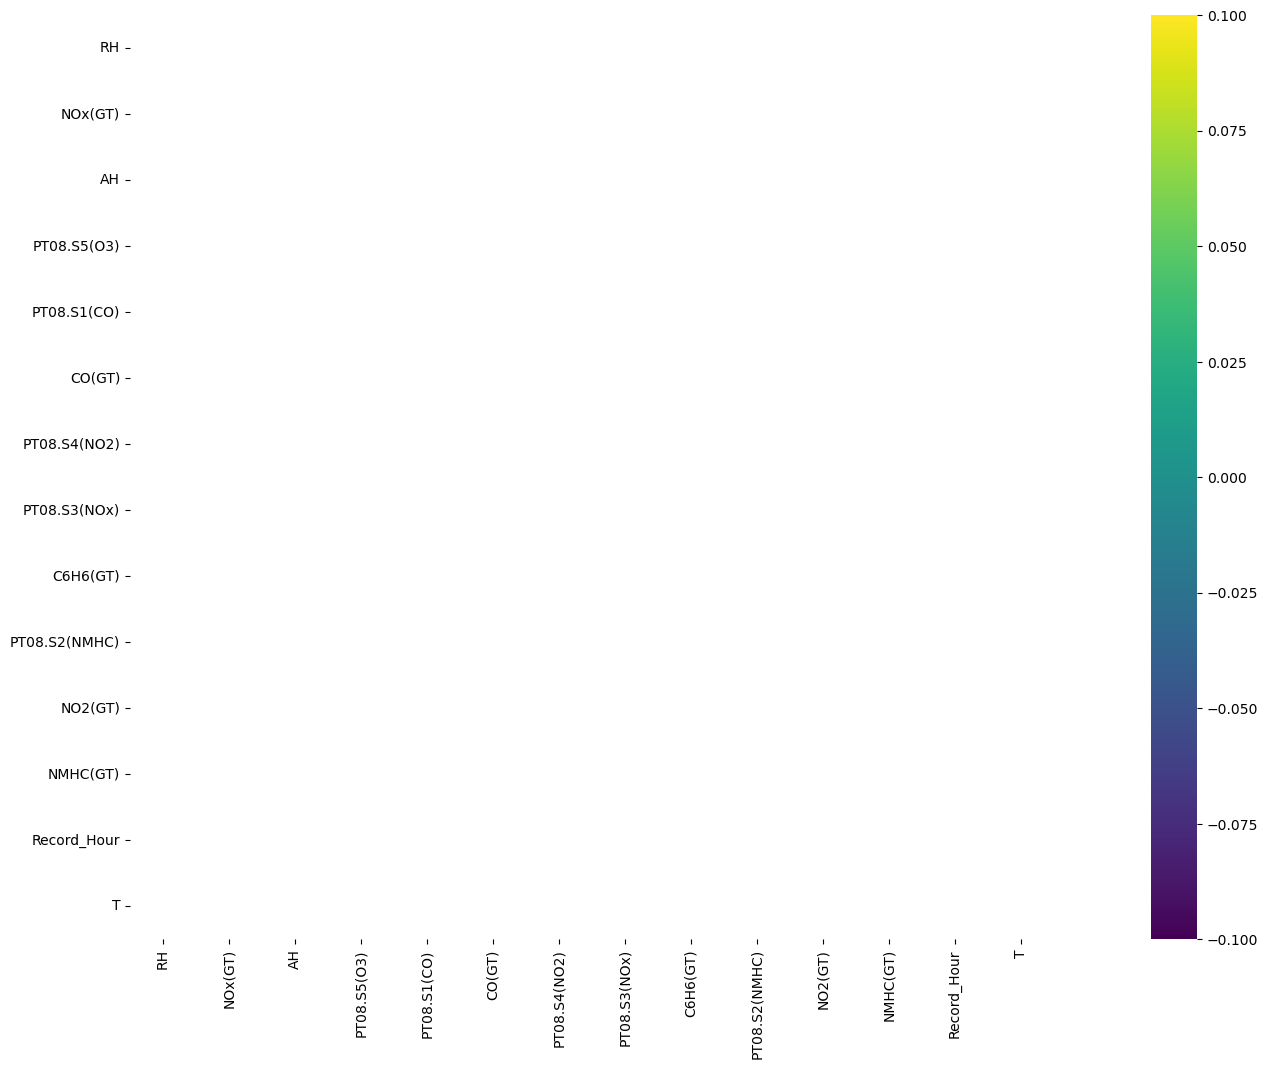

In [10]:
k= air_quality.select_dtypes(include=[np.number]).columns.size
correlation = air_quality.select_dtypes(include=[np.number]).corr()
#Build correlation matrix for target variable
cols = correlation.nlargest(k,'RH')['RH'].index
cm = np.corrcoef(air_quality[cols].values.T)
f , ax = plt.subplots(figsize = (25,12))
sns.heatmap(cm, vmax=.8, linewidths=0.01,square=True,annot=True,cmap='viridis',
            linecolor="white",xticklabels = cols.values ,annot_kws = {'size':10},yticklabels = cols.values)

#### Inference
There are some very high correlated predictor variables. We must clean this up
1. NOx(GT) is highly correlated with CO(GT), hence, we shall take only 1 of them. Since, NOx(GT) has higher correlation with target variable, we keep it and drop CO(GT)
2. PT08.S5(O3) is highly correlated with PT08.S1(CO), hence, we shall take only 1 of them. Since, PT08.S5(O3) has higher correlation with target variable, we keep it and drop PT08.S1(CO)
3. PT08.S5(O3) and CO(GT) are again twins. We have already dropped CO(GT)
4. PT08.S4(NO2) and C6H6(GT) and PT08.S2(NMHC) and triplets. We drop C6H6(GT) and PT08.S2(NMHC)

In [11]:
air_quality.drop(['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)'], axis = 1, inplace = True)

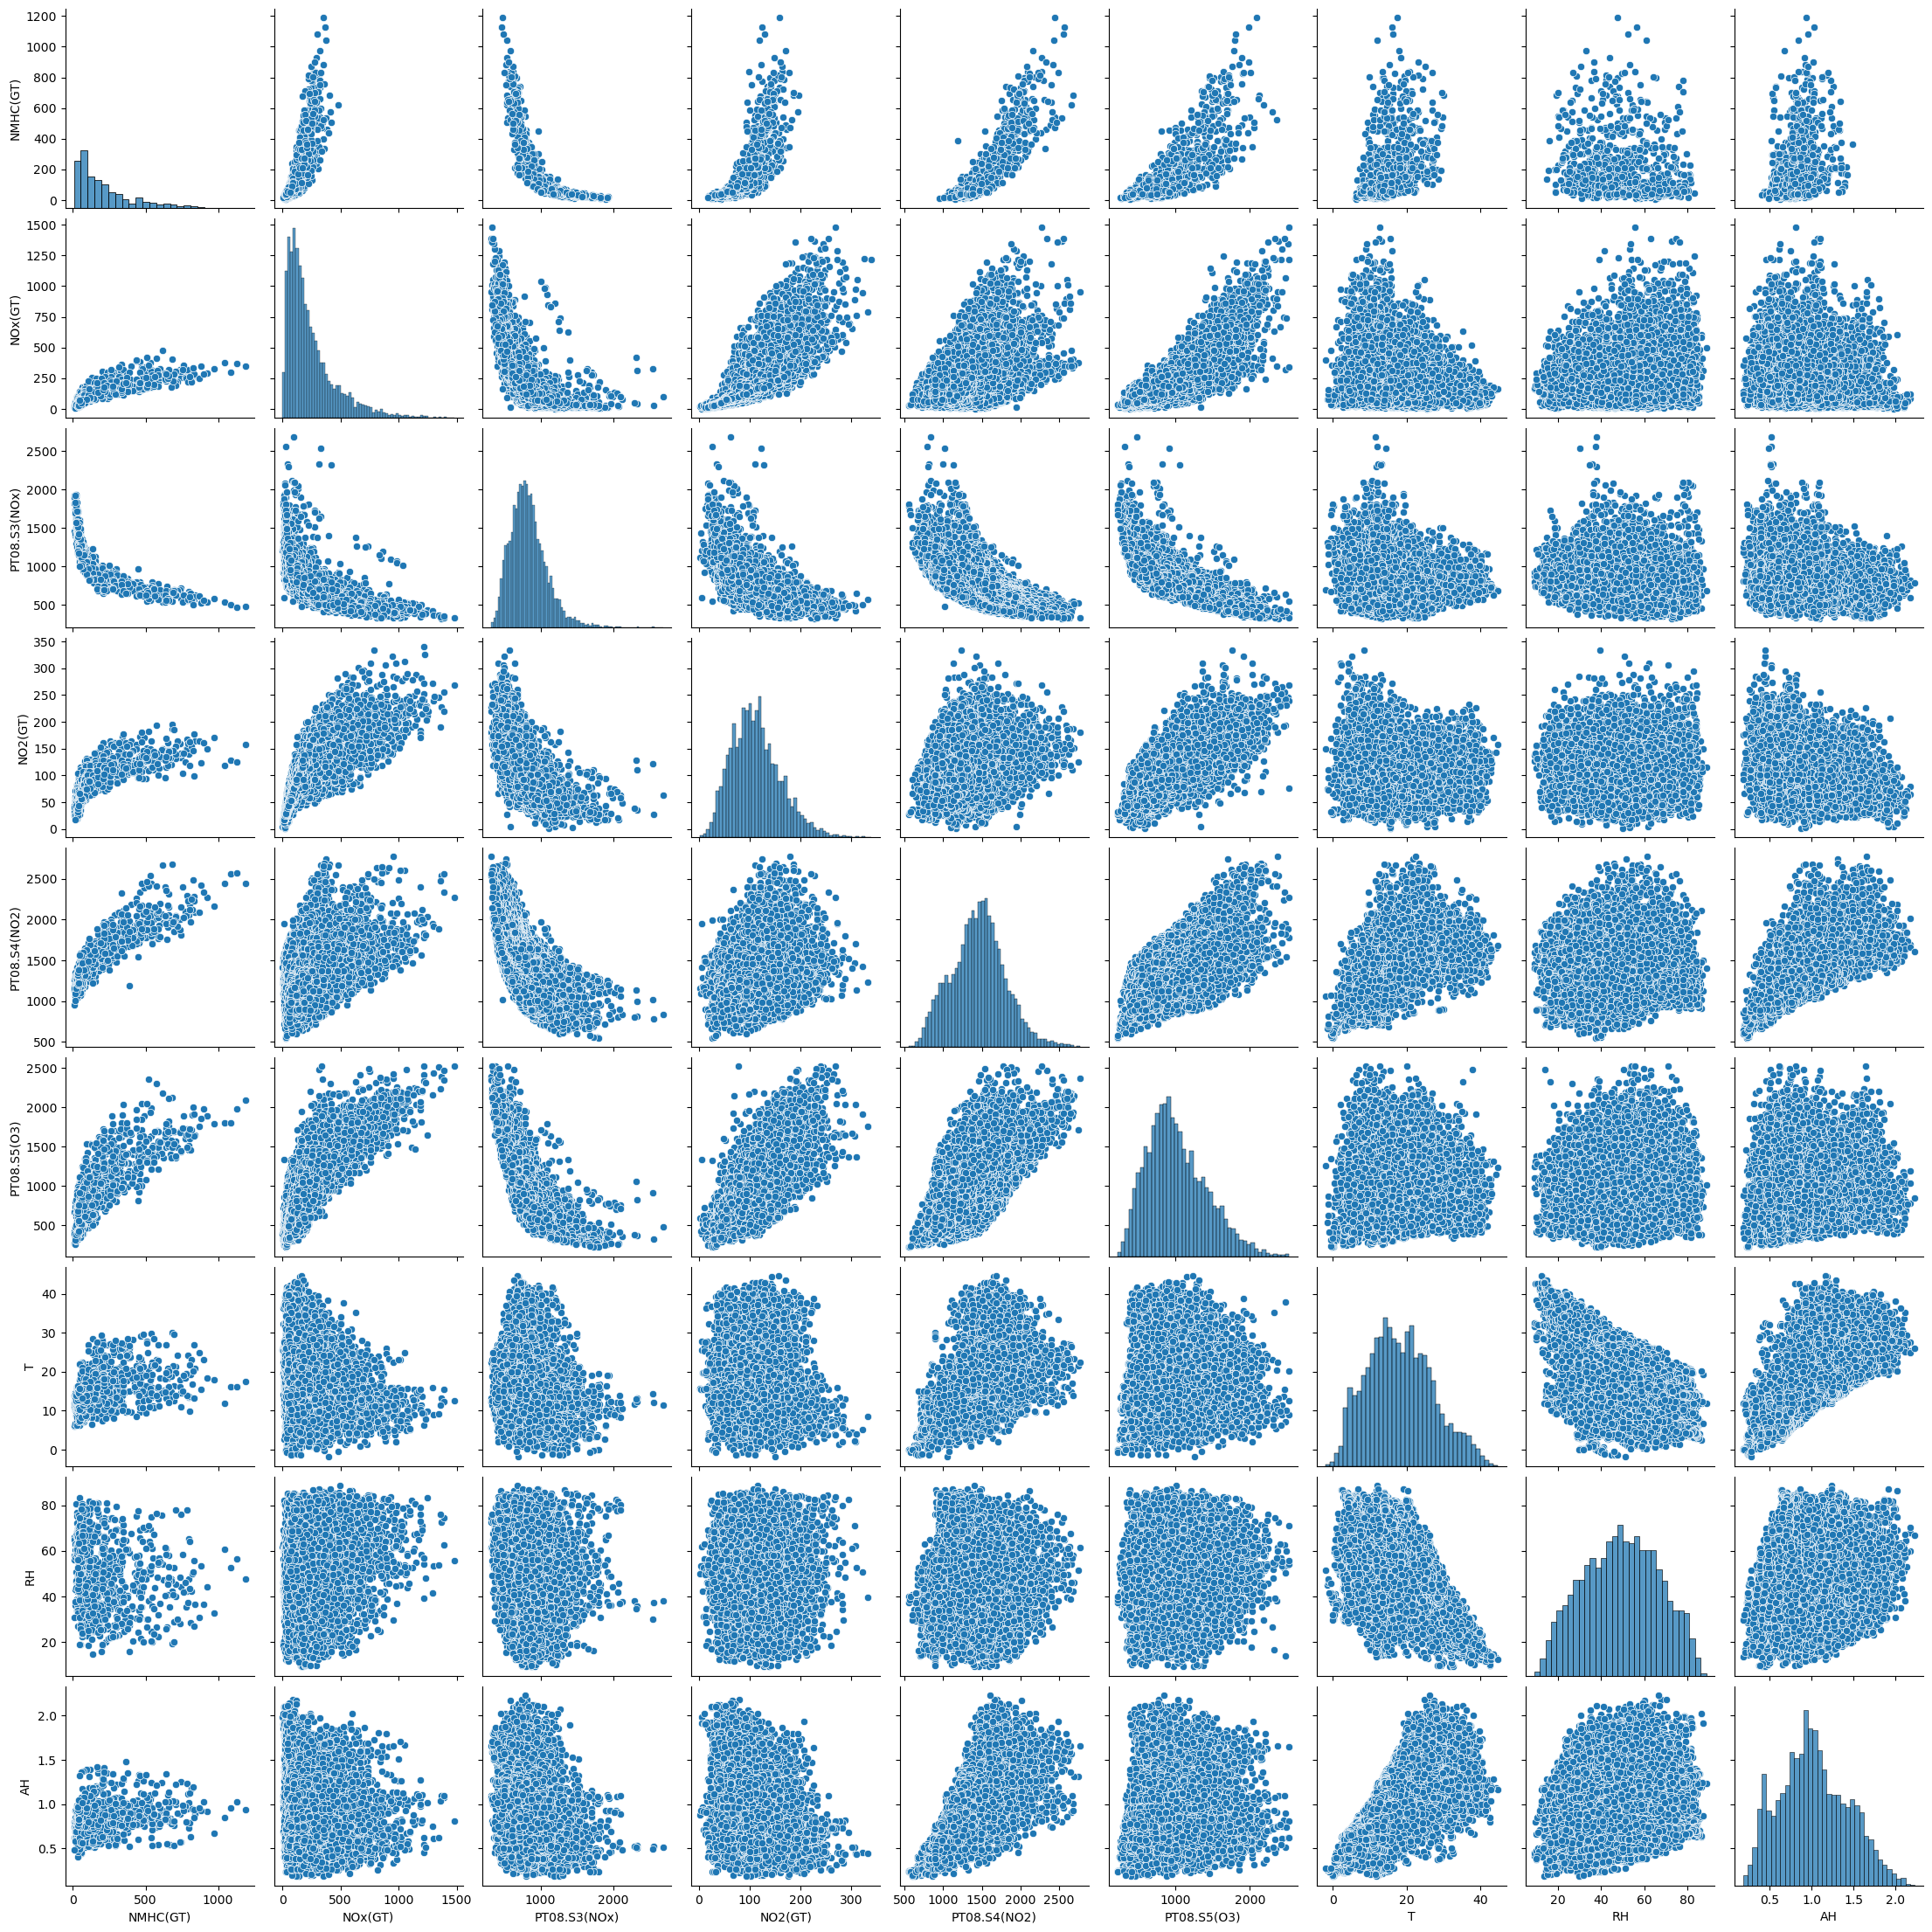

In [12]:
sns.pairplot(air_quality, palette="husl", vars = ['NMHC(GT)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH'])

plt.show()

#### Inference
The Pair Plot shows +ve correlation between some variable, -ve correlation with some variables.
The output variable(RH) does nt shows either +ve or -ve correclation with some variables - NO2(GT), PT08.S4(NO2), PT08.S5(O3)

### Feature Engineering

In [13]:
#Fature extraction from the Record_Date column
air_quality['Month'] = air_quality.Record_Date.dt.month
air_quality['DateOfMonth'] = air_quality.Record_Date.dt.day
air_quality['Weekday'] = air_quality.Record_Date.dt.weekday
#Add another column if the day is a weekday or weekend
air_quality['Weekend'] = air_quality.Weekday.apply(lambda x: 0 if ((x >= 0) & (x < 5)) else 1)

#Now, that we have extracted most of the info from Record_Date column, we drop this column
air_quality.drop('Record_Date', axis = 1, inplace = True)
air_quality.sample(5)

,Record_Hour,NMHC(GT),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Month,DateOfMonth,Weekday,Weekend
6033,3.0,NaN,NaN,1150.0,NaN,930.0,752.0,7.9,55.4,0.5930,11,17,2,0
766,16.0,66.0,55.0,1348.0,58.0,1150.0,394.0,21.0,23.6,0.5788,4,11,6,1
9075,21.0,NaN,551.0,464.0,194.0,1500.0,1844.0,18.8,37.3,0.8031,3,23,2,0
1537,19.0,NaN,204.0,612.0,133.0,2076.0,1489.0,19.8,47.9,1.0920,5,13,3,0
7755,21.0,NaN,243.0,863.0,168.0,911.0,909.0,4.5,39.9,0.3390,1,27,3,0


### How is the monthly pattern of air quality?

<Axes: xlabel='Month', ylabel='NO2(GT)'>

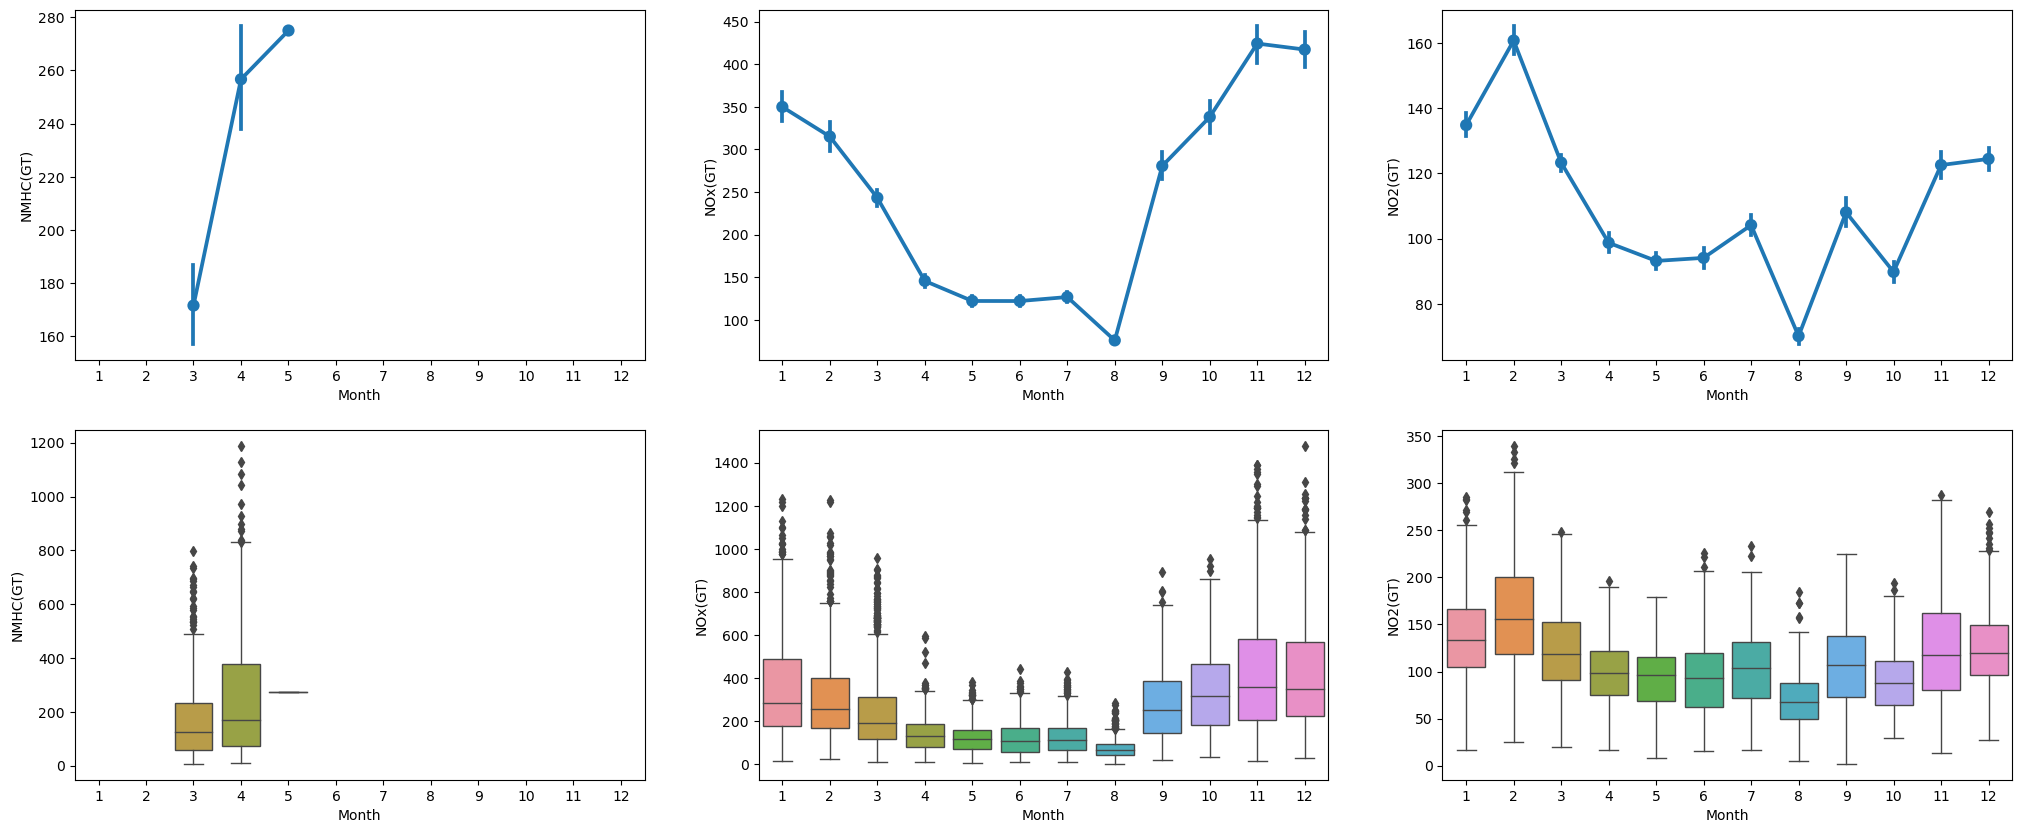

In [14]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(25,10))
sns.pointplot(x="Month", y="NMHC(GT)", data=air_quality, ax = ax1)
sns.pointplot(x="Month", y="NOx(GT)", data=air_quality, ax = ax2)
sns.pointplot(x="Month", y="NO2(GT)", data=air_quality, ax = ax3)
sns.boxplot(x='Month', y='NMHC(GT)', data=air_quality, linewidth=1, ax = ax4)
sns.boxplot(x='Month', y='NOx(GT)', data=air_quality, linewidth=1, ax = ax5)
sns.boxplot(x='Month', y='NO2(GT)', data=air_quality, linewidth=1, ax = ax6)

<Axes: xlabel='Month', ylabel='T'>

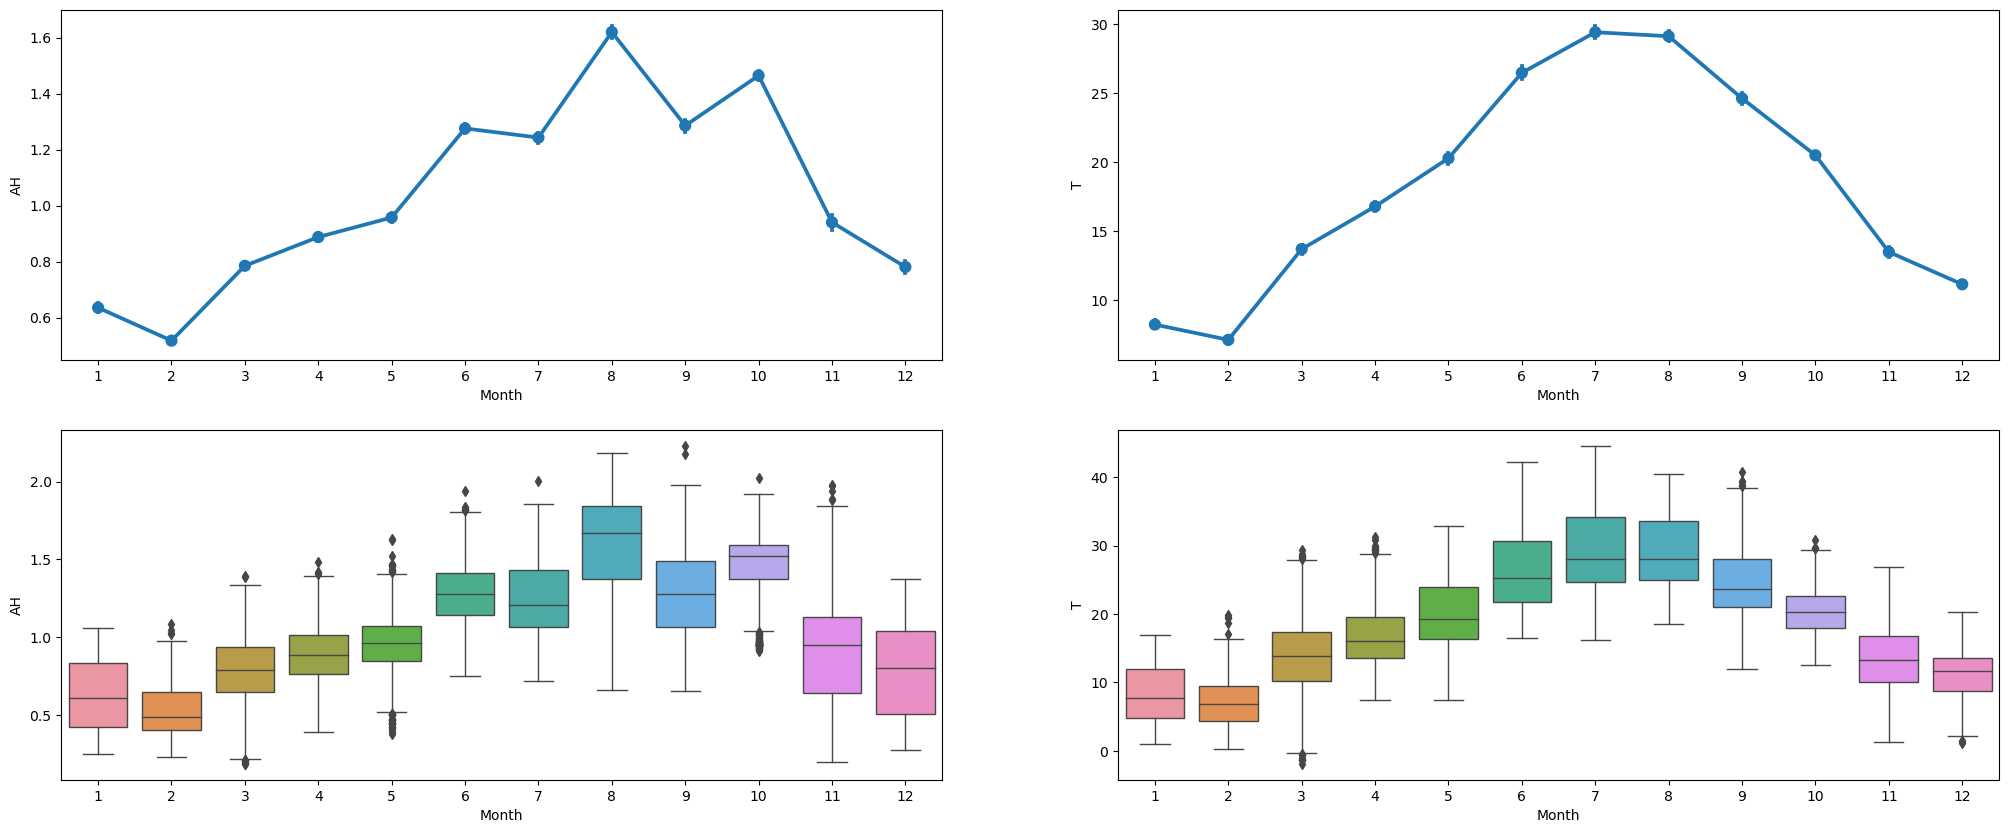

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(25,10))
sns.pointplot(x="Month", y="AH", data=air_quality, ax = ax1)
sns.pointplot(x="Month", y="T", data=air_quality, ax = ax2)
#sns.pointplot(x="Month", y="NO2(GT)", data=air_quality, ax = ax3)
sns.boxplot(x='Month', y='AH', data=air_quality, linewidth=1, ax = ax3)
sns.boxplot(x='Month', y='T', data=air_quality, linewidth=1, ax = ax4)
#sns.boxplot(x='Month', y='NO2(GT)', data=air_quality, linewidth=1, ax = ax6)

#### Inference
1. Colder months(September to February) show higher concentration of NOx
2. NMHC shows sudden dip in level in March and April. For other months, its nearly the same
3. NO2 shows high value in Jan and Feb compared to other months
4. Absolute Humidity goes higher during rainy season(June to October) where as the temperature goes higher during su

In [16]:
# Lets do binning of temperature
temp_bin = np.arange(-5,50,5)
bin_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
air_quality['Temp_Bin'] = pd.cut(air_quality['T'], bins = temp_bin, labels = bin_labels, right = True).astype('int64')
air_quality.sample(5)

ValueError: Cannot convert float NaN to integer

### How is air quality on a weekday Vs the weekend?

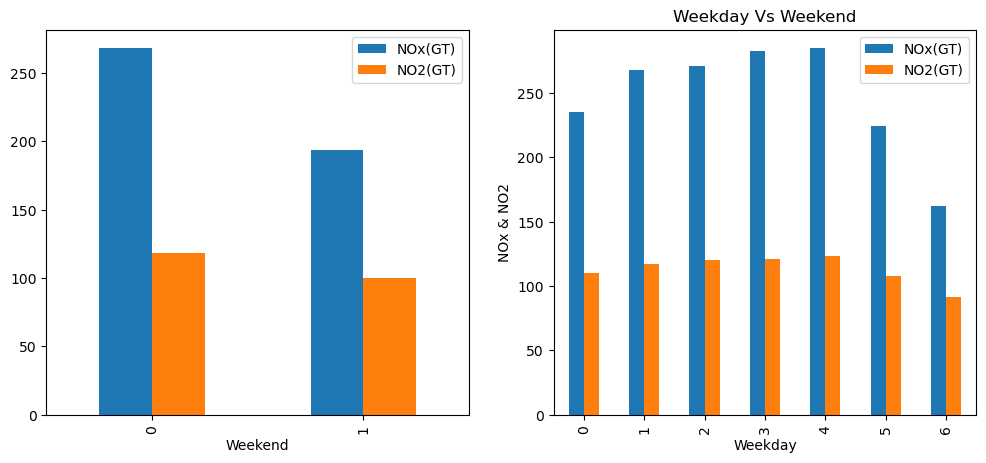

In [17]:
#You can normalise the data as percentage
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(25,6))
WeekendVsWeekday = air_quality[['NOx(GT)', 'NO2(GT)', 'Weekend']].groupby('Weekend').mean().reset_index().set_index('Weekend')
WeekendVsWeekday.plot.bar(figsize=(12,5), ax = ax1)
plt.title('Weekday Vs Weekend')
plt.ylabel("NOx & NO2")
#for getting the values on each bar
for i in ax.patches:
    ax.annotate(i.get_height(), (i.get_x(), i.get_height()))
    
WeekendVsWeekday = air_quality[['NOx(GT)', 'NO2(GT)', 'Weekday']].groupby('Weekday').mean().reset_index().set_index('Weekday')
WeekendVsWeekday.plot.bar(figsize=(12,5), ax = ax2)
plt.title('Weekday Vs Weekend')
plt.ylabel("NOx & NO2")
#for getting the values on each bar
for i in ax.patches:
    ax.annotate(i.get_height(), (i.get_x(), i.get_height()))


#### Inference
1. The NOx and NO2 levels on weekends are considerably lower than on Weekdays
2. The NOx levels is cosiderably lower on Monday among weekdays

In [18]:
# We can also check if the change in gas concentrations over time has any effect on the temperature change. So to do this, \
# we need new variables which are the difference of consecutive values of gas concentrations compared with difference of \
# values of temperature to compare if both differenced parameters have any relationship between them.
air_quality['dNMHC'] = air_quality['NMHC(GT)'] - air_quality['NMHC(GT)'].shift(-1)
air_quality['dNOx'] = air_quality['NOx(GT)'] - air_quality['NOx(GT)'].shift(-1)
air_quality['dNO2'] = air_quality['NO2(GT)'] - air_quality['NO2(GT)'].shift(-1)
air_quality.fillna(0, inplace = True)

In [19]:
# Output the Dataframe into a CSV file
air_quality.to_csv('Air_Quality_EDA.csv',  index = False, escapechar = '-')